In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from hankel import HankelTransform

First computing: 

$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

1. Compute for the peak positions of the parameters (truth)
2. Sample 100 parameters from posterior 
3. Compute and plot the average (median) and 1 standard dev (uncertainty estimate)

Question: is N(r) in initial condition given by

$$  N(r_T) = 1 - exp [ - \frac{r_T^2 Q_{s0}^2}{4}  ln ( \frac{1}{r_T \Lambda_{QCD}} + e_c \cdot e) ] $$

if so where does C² come into play?

When S(k) is obtained we are then able to get the leading order protom - nucleus cross sections in the hybrid formalism

$$ \frac{dN(b_T)}{dy d²k_T} = \frac{1}{(2\pi²)} xg(x, k_T²) \tilde{S}^A (k_T) $$ 

where $S^A(k_T)$ is obtained from

$$ N^A(r_T, b_T) = 1 - exp [ - A T_A(b_T) \frac{\sigma_0}{2} \frac{r_T^2 Q_{s0}^2}{4}  ln ( \frac{1}{r_T \Lambda_{QCD}} + e_c \cdot e) ]  $$

where $T_A$ is the Woods-Saxon nuclear density. Because the fully impact parameter dependent BK equation develops unphysical Coulomb tails, the scattering amplitudes are solved for each b_T independently. Not reliable in region $b_T \geq 6.3 fm$. The wood saxon nuclear density is the transverse thickness function of the nucleus obtained by integrating the Woods-Saxon distribution

$$ \rho_A(b_T, z) = \frac{n}{1 + exp [\frac{\sqrt{b_T^2 + z^2} + R_A}{d}]} $$

given d = 0.54 fm and $R_A = (1.12 A^{1/3} - 0.86 A^{-1/3})$ fm.


In [58]:
# how to use hankel transform
# define initial parameters of hankel transformation

ht = HankelTransform(nu = 0, # order of Bessel function
                     N = 1000, # Number of steps in integration
                     h = 0.001 # Proxy for size of steps
                     ) 

# and the values of the mve parametrization
Qs02 = 0.077 #GeV^2 
e_c = 7.835 
sigma0_2 = 15.199 #GeV^-2
# get uncertainty/ get samples from the distribution

# define the function to transform

def dipp(r, Qs02, e_c, sigma0_2):
    lambda_qcd = 0.241 #GeV
    B = (r**2)*(Qs02)
    C = (1/(r*lambda_qcd) + e_c * np.exp(1))
    N = 1 - np.exp(-B/4 * np.log(C))
    return N

def rho(z, bt, n):
    RA = 1.12*A**(1/3) - 0.86*A**(-1/3) # fm
    d = 0.54 # fm 
    # 5.068 fm = 1 GeV^-1 
    rhoA = n / (1 + np.exp((np.sqrt(bt**2 + z**2) + RA)/d))
    return rhoA

def woods_saxon(bt, n):
    TA = integrate.quad(rho, -np.inf(), np.inf(), args = (bt, n))
    return TA[0]

def woods_saxon_4norm(bt, n): # just the previous function but times 2 pi bt
    TA = integrate.quad(rho, 0.0, 1.0, args = (bt, n))
    return 2 * np.pi * bt * TA[0]

def woods_saxon_norm():
    a = 1
    ta_norm = integrate.quad(woods_saxon_4norm, 0.0, 10.0, args=(a))
    n = 1  / ta_norm[0]    
    return n

def dipA(r, A):
    lambda_qcd = 0.241 #GeV
    bt = 0.5 
    n = woods_saxon_norm()
    TA = woods_saxon(bt, n) 
    B = A * TA * (sigma0_2)*(r**2)*(Qs02)
    C = 1/(r*lambda_qcd) + e_c * np.exp(1)
    N = 1 - np.exp(-B/4 * np.log(C))
    return N

A = 1 # let's just let A be a proton now
func = lambda r: 1 - dipp(r)
func2 = lambda r: 1 - dipA(r, A)
k = np.logspace(-1,1,50)   
sp = ht.transform(func, k, ret_err = False)
spA = ht.transform(func2, k, ret_err = False)

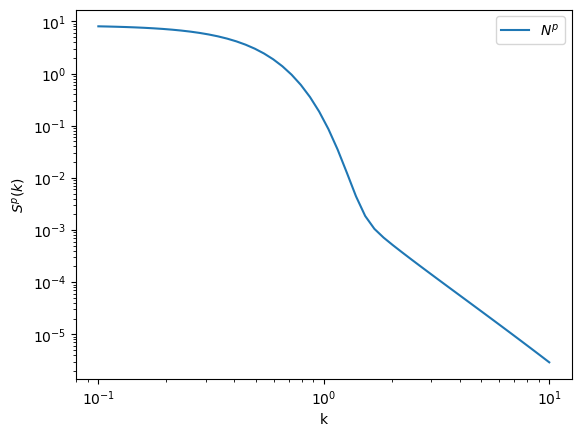

In [70]:
plt.plot(k, sp, label = '$N^{p}$')
#plt.plot(k, spA, label = '$N^{A}(A = 1)$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$S^p(k)$')
plt.xlabel('k')
plt.legend()